# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Load Data

In [2]:
column_descrip = pd.read_csv('../../data/raw/usgs/usgs_data_dictionary.csv')

useful_columns = ['case_id','t_state','t_county','t_fips','p_name','p_year',
                  'p_tnum','p_cap','t_manu','t_model','t_cap','t_hh','t_rd',
                  't_rsa','t_ttlh','xlong','ylat']

column_descrip[column_descrip['field'].isin(useful_columns)][['field','description']]

,field,description
0,case_id,unique uswtdb id
5,t_state,state where turbine is located
6,t_county,county where turbine is located
7,t_fips,state and county fips where turbine is located
8,p_name,project name
9,p_year,year project became operational
10,p_tnum,number of turbines in project
11,p_cap,project capacity (MW)
12,t_manu,turbine original equipment manufacturer
13,t_model,turbine model


In [3]:
df = pd.read_csv('../../data/raw/usgs/usgs_data.csv',
                 engine='python',encoding='latin1',usecols=useful_columns)
# We want only New York data
df = df[df.t_state=='NY']
df.head()

,case_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh,xlong,ylat
1528,3075480,NY,Chautauqua County,36013,Arkwright Summit,2018.0,36,78.4,Vestas,V110-2.0,2200.0,95.0,110.0,9503.32,150.0,-79.230286,42.395222
1529,3075488,NY,Chautauqua County,36013,Arkwright Summit,2018.0,36,78.4,Vestas,V110-2.0,2200.0,95.0,110.0,9503.32,150.0,-79.245026,42.427578
1530,3075460,NY,Chautauqua County,36013,Arkwright Summit,2018.0,36,78.4,Vestas,V110-2.0,2200.0,95.0,110.0,9503.32,150.0,-79.222168,42.388699
1531,3075489,NY,Chautauqua County,36013,Arkwright Summit,2018.0,36,78.4,Vestas,V110-2.0,2000.0,95.0,110.0,9503.32,150.0,-79.252396,42.430599
1532,3075456,NY,Chautauqua County,36013,Arkwright Summit,2018.0,36,78.4,Vestas,V110-2.0,2000.0,95.0,110.0,9503.32,150.0,-79.232803,42.430202


# Compute Blade Lengths

We can approximate length of a turbine blade in two ways:

1. Rotor diameter / 2
2. Total height - Hub Height




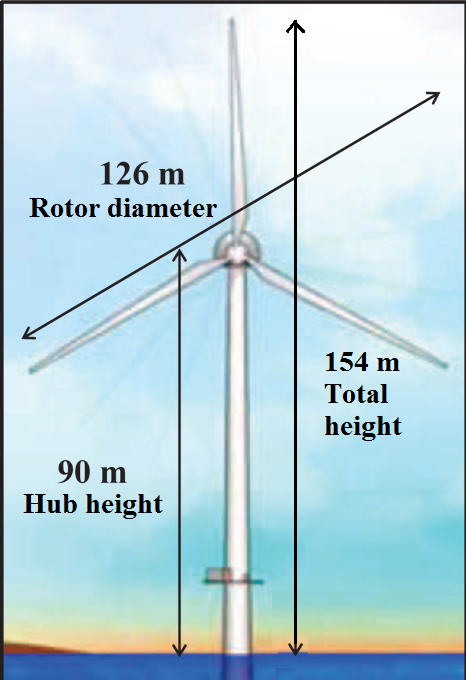



In [4]:
df['blade_length_1'] = df['t_ttlh'] - df['t_hh']
df['blade_length_2'] = df['t_rd'] / 2

In [5]:
np.nanmean(df['blade_length_1'] - df['blade_length_2'])

0.04868977176669207

Both methods lead to pretty much the same blade length. On average, the difference between the two methods is .05 meters $\approx$ 1.6 inches.

In [6]:
# Let's use method2
df['blade_length'] = df['blade_length_2']
df = df.drop(['blade_length_1','blade_length_2'],axis=1)

# EDAV Blade Length

<AxesSubplot:xlabel='blade_length', ylabel='Count'>

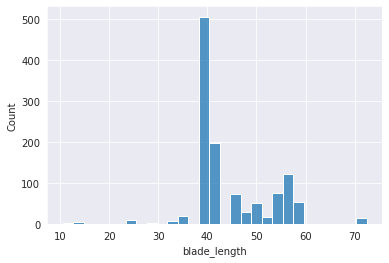

In [7]:
# blade length can vary pretty wildly, but most are around 40 meters
sns.histplot(data=df,x='blade_length')

In [8]:
# avg blade length
np.mean(df.blade_length)

44.13505067567568

In [9]:
turbine_info  = pd.DataFrame(df.groupby(['t_manu','t_model'])['blade_length'].agg(['count','mean','var'])).sort_values(by=['count'],ascending=False)
turbine_info.columns = ['count','mean_length','var_length']
turbine_info

count  mean_length  var_length
t_manu                          t_model                                     
GE Wind                         GE1.5-77        506    38.500000    0.000000
Vestas                          V82-1.65        194    41.000000    0.000000
                                V110-2.0         76    55.000000    0.000000
                                V112-3.075       70    56.000000    0.000000
GE Wind                         GE1.62-100       52    50.000000    0.000000
Gamesa                          G90-2.0          37    45.000000    0.000000
                                G114-2.1         37    57.000000    0.000000
Clipper                         C96              29    48.000000    0.000000
REpower                         MM92             27    46.240741    0.002315
Nordex                          N117/3675        27    58.500000    0.000000
GE Wind                         GE2.5-116        27    58.000000    0.000000
                                GE1.5-70.5       19    35.250000    0.000000
                                GE1.62-103       16    51.500000    0.000000
Siemens Gamesa Renewable Energy SG-2.625-114     15    57.000000    0.000000
                                SG-4.5-145       15    72.500000    0.000000
Vestas                          V47-0.66         10    23.500000    0.000000
Clipper                         C93               8    46.500000    0.000000
Vestas                          V66-1.65          7    33.000000    0.000000
Vergnet                         GEV MP-R          4    14.500000    0.000000
Hyundai                         HQ1650            2    41.000000    0.000000
Gamesa                          G58-0.85          1    29.000000         NaN
Goldwind                        GW82              1    41.000000         NaN
Northern Power Systems          NPS-100           1    10.500000         NaN
                                NW100             1    10.500000         NaN
Vensys                          Vensys82          1    41.150000         NaN
Fuhrlander                      FL250             1    14.500000         NaN

# Emission Approximation

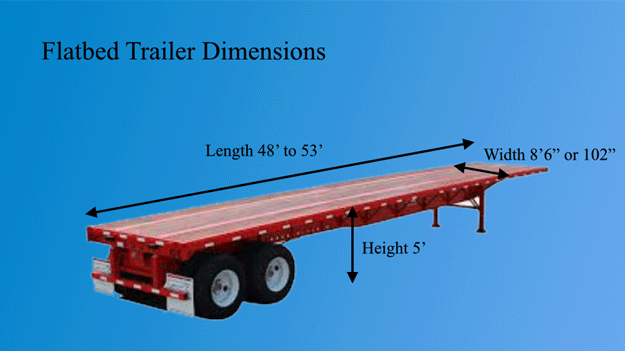

Let's assume a flatbed is 53 feet $\approx$ 16.2 meters.

For the sake of simplicity, let's say we can breakdown windmill blades before transport

In [10]:
turbine_info = turbine_info.drop('var_length',axis=1)
turbine_info.columns = ['numb_turbines','turbine_blade_length']
turbine_info['numb_flatbed_for_transport'] = (turbine_info['turbine_blade_length']/16.2).apply(np.ceil)

In [11]:
turbine_info = turbine_info.sort_values(by='numb_flatbed_for_transport',ascending = False)
turbine_info.head()

numb_turbines  \
t_manu                          t_model                       
Siemens Gamesa Renewable Energy SG-4.5-145               15   
                                SG-2.625-114             15   
Vestas                          V110-2.0                 76   
                                V112-3.075               70   
GE Wind                         GE1.62-100               52   

                                              turbine_blade_length  \
t_manu                          t_model                              
Siemens Gamesa Renewable Energy SG-4.5-145                    72.5   
                                SG-2.625-114                  57.0   
Vestas                          V110-2.0                      55.0   
                                V112-3.075                    56.0   
GE Wind                         GE1.62-100                    50.0   

                                              numb_flatbed_for_transport  
t_manu                          t_model                                   
Siemens Gamesa Renewable Energy SG-4.5-145                           5.0  
                                SG-2.625-114                         4.0  
Vestas                          V110-2.0                             4.0  
                                V112-3.075                           4.0  
GE Wind                         GE1.62-100                           4.0

From the environmental defense fund:

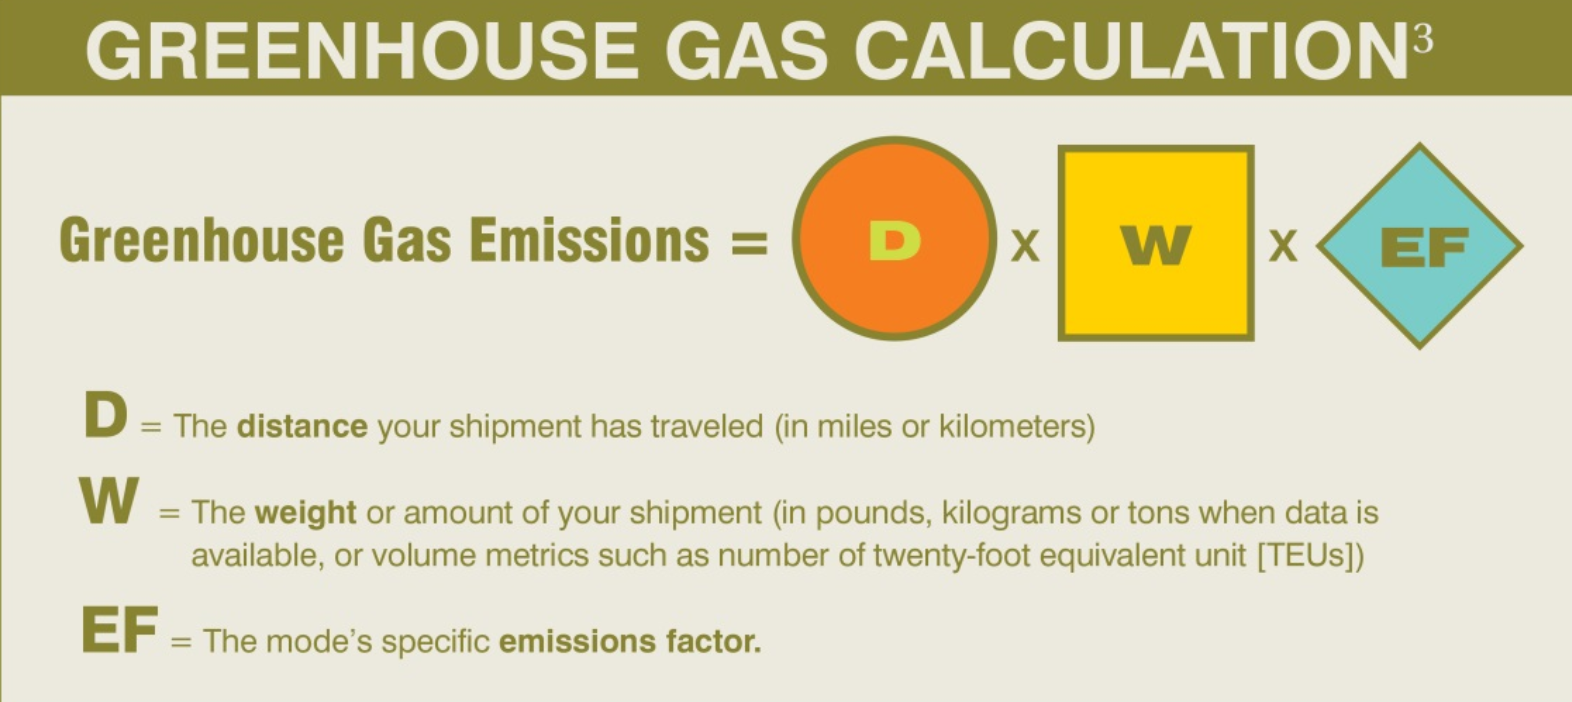

In [12]:
turbine_info  = pd.DataFrame(df.groupby(['t_manu','t_model'])['blade_length'].agg(['count','mean','var'])).sort_values(by=['mean'],ascending=False)
turbine_info

count       mean       var
t_manu                          t_model                                 
Siemens Gamesa Renewable Energy SG-4.5-145       15  72.500000  0.000000
Nordex                          N117/3675        27  58.500000  0.000000
GE Wind                         GE2.5-116        27  58.000000  0.000000
Gamesa                          G114-2.1         37  57.000000  0.000000
Siemens Gamesa Renewable Energy SG-2.625-114     15  57.000000  0.000000
Vestas                          V112-3.075       70  56.000000  0.000000
                                V110-2.0         76  55.000000  0.000000
GE Wind                         GE1.62-103       16  51.500000  0.000000
                                GE1.62-100       52  50.000000  0.000000
Clipper                         C96              29  48.000000  0.000000
                                C93               8  46.500000  0.000000
REpower                         MM92             27  46.240741  0.002315
Gamesa                          G90-2.0          37  45.000000  0.000000
Vensys                          Vensys82          1  41.150000       NaN
Goldwind                        GW82              1  41.000000       NaN
Hyundai                         HQ1650            2  41.000000  0.000000
Vestas                          V82-1.65        194  41.000000  0.000000
GE Wind                         GE1.5-77        506  38.500000  0.000000
                                GE1.5-70.5       19  35.250000  0.000000
Vestas                          V66-1.65          7  33.000000  0.000000
Gamesa                          G58-0.85          1  29.000000       NaN
Vestas                          V47-0.66         10  23.500000  0.000000
Vergnet                         GEV MP-R          4  14.500000  0.000000
Fuhrlander                      FL250             1  14.500000       NaN
Northern Power Systems          NPS-100           1  10.500000       NaN
                                NW100             1  10.500000       NaN

In [13]:
# Low estimate of turbine blade weight is 5,200 lbs
# Flatbeds have emission factor of 1,800